## Task 1: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [33]:
!pip install nlp

In [34]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [35]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [36]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [37]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [38]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [39]:
tweets, labels = get_tweet(train)

In [40]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [42]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK')
tokenizer.fit_on_texts(tweets)

In [43]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

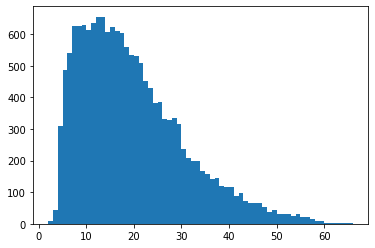

In [44]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [45]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
def get_sequence(tokenizer,tweets):
  sequence = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequence, truncating='post', padding='post',maxlen=maxlen)
  return padded

In [47]:
padded_train_seq = get_sequence(tokenizer, tweets)

In [48]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [49]:
classes = set(labels)
print(classes)

{'joy', 'sadness', 'surprise', 'love', 'fear', 'anger'}


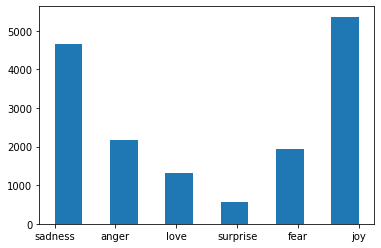

In [50]:
plt.hist(labels,bins = 11)
plt.show()

In [51]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [52]:
class_to_index

{'anger': 5, 'fear': 4, 'joy': 0, 'love': 3, 'sadness': 1, 'surprise': 2}

In [53]:
index_to_class

{0: 'joy', 1: 'sadness', 2: 'surprise', 3: 'love', 4: 'fear', 5: 'anger'}

In [54]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [55]:
train_labels = names_to_ids(labels)
print(train_labels[2])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [56]:
model = tf . keras . models . Sequential( [
                                           tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
                                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                           tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss= 'sparse_categorical_crossentropy' ,
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [58]:
val_tweets,val_labels = get_tweet(val)
val_seq = get_sequence(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)

In [59]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [61]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks= [
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)


Epoch 1/20
500/500 [==============================] - 20s 18ms/step - loss: 1.3505 - accuracy: 0.4741 - val_loss: 1.0007 - val_accuracy: 0.6170
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.6955 - accuracy: 0.7607 - val_loss: 0.5100 - val_accuracy: 0.8365
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3202 - accuracy: 0.8980 - val_loss: 0.3849 - val_accuracy: 0.8710
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1925 - accuracy: 0.9388 - val_loss: 0.3814 - val_accuracy: 0.8760
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1410 - accuracy: 0.9546 - val_loss: 0.4208 - val_accuracy: 0.8720
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1131 - accuracy: 0.9647 - val_loss: 0.3755 - val_accuracy: 0.8885
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0881 - accuracy: 0.9723 - val_loss: 0.3809 - val_accuracy: 0.887

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

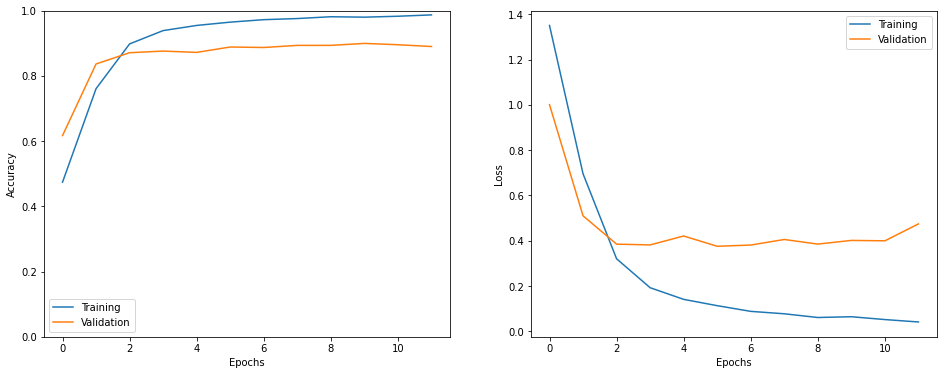

In [62]:
show_history(h)

In [64]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequence(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [65]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4911 - accuracy: 0.8810


In [73]:
i = random.randint(0,len(test_labels)-1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  i have a feeling i will be dissatisfied several times
Emotion:  anger
Predicted Emotion:  anger


In [75]:
preds = model.predict_classes(test_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


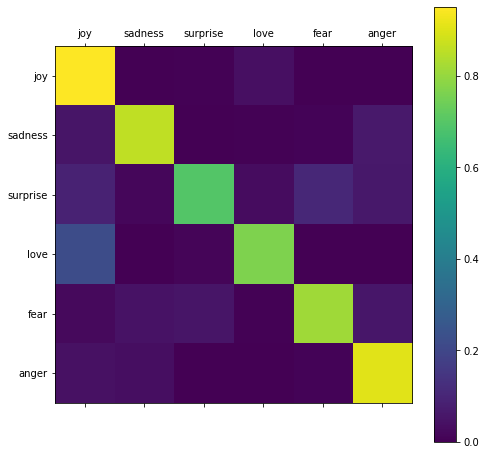

In [76]:
show_confusion_matrix(test_labels,preds, list(classes))